# Execução do código de 100%

O código abaixo foi feito seguindo o modelo proposto em https://www.kaggle.com/code/muki2003/count-finger-accurancy-100/notebook 

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
import os
import random
import matplotlib.pyplot as plt

In [21]:
trainpath = os.listdir("../train")
testpath = os.listdir("../test")

In [22]:
porcentagem_do_dataset = .1

In [23]:
trainpath = trainpath[ :int(len(trainpath) * porcentagem_do_dataset) ]
testpath = testpath[ :int(len(testpath) * porcentagem_do_dataset) ]

In [24]:
print(len(trainpath), len(testpath))

1800 360


In [25]:
traindata = ['./train/' + i for i in trainpath]  
testdata = ["./test/" + i for i in testpath]   

In [26]:
print("Tamanho treinamento:", len(traindata))
print("Tamanho teste:", len(testdata))


Tamanho treinamento: 1800
Tamanho teste: 360


In [58]:
traindata = pd.DataFrame(traindata, columns=['Filepath'])
testdata = pd.DataFrame(testdata, columns=['Filepath'])

traindata['target'] = traindata['Filepath'].apply(lambda a: a[-6:-5])
testdata['target'] = testdata['Filepath'].apply(lambda a: a[-6:-5])

In [59]:
traindata

,Filepath,target
0,./train/000cac8e-fcf0-4f8c-bd16-c257d1e6d7a8_2...,2
1,./train/000d9961-8136-4dee-9820-86e178777958_0...,0
2,./train/00a32b09-1b9a-4198-b58a-b85fd24797da_4...,4
3,./train/00a3805e-d549-46b2-bdd7-f1e47d7ff35e_5...,5
4,./train/00a4ef2f-d6fe-49b9-acdf-c0d1092916da_1...,1
...,...,...
345,./train/0e2fe6f6-ae9a-4ad4-bd4b-3bd2e9f873f0_3...,3
346,./train/0e3feb99-70ed-404b-b599-3950e91bc773_5...,5
347,./train/0e4b3a60-e619-4015-9313-457336d85c2a_5...,5
348,./train/0e4bf764-cd27-4137-9492-6367bda73f28_1...,1


In [60]:
ds_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,validation_split=0.1)

In [61]:
train_ds = ds_generator.flow_from_dataframe(dataframe=traindata,x_col='Filepath',y_col='target',target_size=(224, 224),color_mode='rgb',class_mode='categorical',batch_size=16,subset='training')
val_ds = ds_generator.flow_from_dataframe(dataframe=traindata,x_col='Filepath',y_col='target',target_size=(224, 224),color_mode='rgb',class_mode='categorical',batch_size=16,subset='validation')
test_ds = ds_generator.flow_from_dataframe(dataframe=testdata,x_col='Filepath',y_col='target',target_size=(224, 224),color_mode='rgb',class_mode='categorical',batch_size=16)

Found 315 validated image filenames belonging to 6 classes.
Found 35 validated image filenames belonging to 6 classes.
Found 150 validated image filenames belonging to 6 classes.


In [62]:
train_ds

In [63]:
val_ds

In [64]:
test_ds

In [65]:
mobile = tf.keras.applications.mobilenet.MobileNet()

mobile.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [66]:
from tensorflow.keras.layers import GlobalAveragePooling2D

x = mobile.layers[-6].output
x = GlobalAveragePooling2D()(x)  # Reduz as dimensões espaciais

output = Dense(units=6, activation='softmax')(x)

# reshape output para ficar no mesmo formato que o target: 
# single_feature_normalizer = tf.keras.layers.Normalization(axis=None)
#output = tf.reshape(ou, shape=(1,n))


model = Model(inputs=mobile.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [67]:
history = model.fit(train_ds, validation_data=val_ds, verbose=1, epochs=2)

Epoch 1/2


C:\Users\mauro\Desktop\Cursos\Atlantico Bootcamp - Machine Learning\Projetos\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - accuracy: 0.7035 - loss: 0.8581 - val_accuracy: 0.4000 - val_loss: 4.1095
Epoch 2/2
20/20 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.9525 - loss: 0.1192 - val_accuracy: 0.3429 - val_loss: 2.8738


In [68]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,661,268 (36.85 MB)

 Trainable params: 3,213,126 (12.26 MB)

 Non-trainable params: 21,888 (85.50 KB)

 Optimizer params: 6,426,254 (24.51 MB)

In [69]:
# model.evaluate(test_ds)
loss, acc = model.evaluate(test_ds)

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 601ms/step - accuracy: 0.3728 - loss: 2.5827


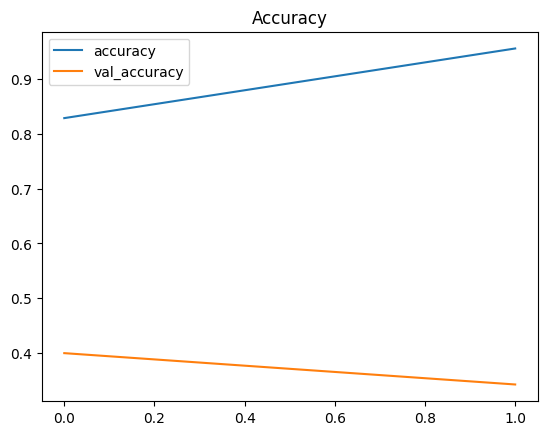

In [71]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

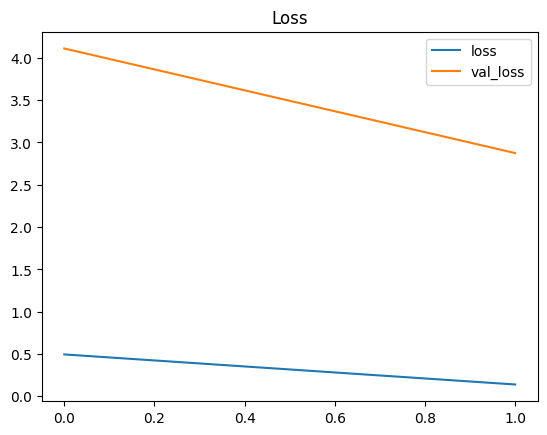

In [72]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [18]:
model.save('./CountFinger1.keras')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


----------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[5 1 1 0 1 0 3 4 3 0 3 1 3 3 3 5]
Seu número foi:  5


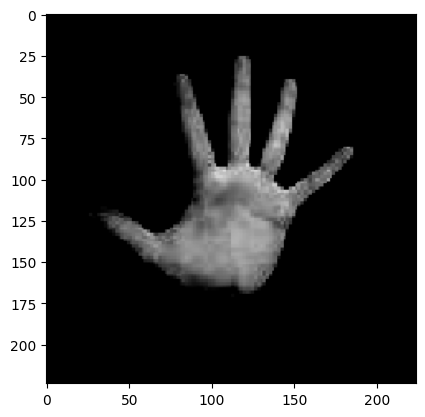

In [19]:
dataiter = iter(test_ds)
imagens, etiquetas = next(dataiter)

plt.imshow( imagens[0], cmap='gray_r')

print("-------" * 10)

resp = model.predict(imagens)
classes = np.argmax(resp, axis = 1)
print(classes)
print("Seu número foi: ", classes[0])